### Your name:

<pre> Jivitesh Shah</pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.simplefilter("ignore")

/Users/jiviteshshah/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### TensorFlow

Q1. When is a variable initialized? When is it destroyed?

To initialize a variable, you need to open a TensorFlow session and use the session to call the initilizer.
Destroyed: When the session ends

Q2. What is the difference between a placeholder and a variable?

Variable: An operation that holds a value. If you run the variable, it returns that value. Before you can run it, you need to initialize it. You can also change the variable's value by assignment operation.

Placeholder: They just hold information about the type and shape of the tensor they represent, but they have no value. You must feed the Tensorflow the value of the placeholder before you evaluate the operation.

Q3. How many times does reverse-mode autodiff need to traverse the graph in order to compute the gradients of the cost function with regards to 10 variables? What about forward-mode autodiff? And symbolic differentiation?

Reverse mode = Only twice
Forward mode = Once

Q4. Implement Logistic Regression with Mini-batch Gradient Descent using TensorFlow. Train it and evaluate it on the moons dataset (introduced in Chapter 5). Try adding all the bells and whistles:

- Define the graph within a logistic_regression() function that can be reused easily.

- Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

- Restore the last checkpoint upon startup if training was interrupted.

- Define the graph using name scopes so the graph looks good in TensorBoard.

- Add summaries to visualize the learning curves in TensorBoard.

- Try tweaking some hyperparameters such as the learning rate or the mini-batch size and look at the shape of the learning curve.

Fetching the moons data set

In [3]:
from sklearn.datasets import make_moons

m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

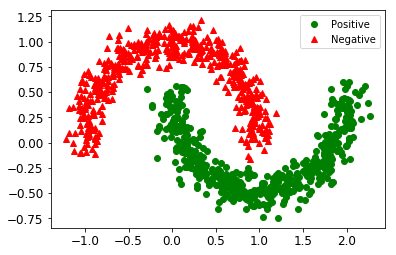

In [4]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [5]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
X_moons_with_bias[:5]

array([[ 1.        , -0.05146968,  0.44419863],
       [ 1.        ,  1.03201691, -0.41974116],
       [ 1.        ,  0.86789186, -0.25482711],
       [ 1.        ,  0.288851  , -0.44866862],
       [ 1.        , -0.83343911,  0.53505665]])

In [6]:
y_moons_column_vector = y_moons.reshape(-1, 1)

In [7]:
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [8]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

define the logistic_regression() function to create the graph.

In [9]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

Function to get the name of the log directory to save the summaries for Tensorboard:

In [10]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [11]:
n_inputs = 6
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Save checkpoints using a Saver at regular intervals during training, and save the final model at the end of training.

In [12]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.8115983
Epoch: 500 	Loss: 0.17487349
Epoch: 1000 	Loss: 0.12642321
Epoch: 1500 	Loss: 0.1019809
Epoch: 2000 	Loss: 0.08697277
Epoch: 2500 	Loss: 0.07674639
Epoch: 3000 	Loss: 0.0693332
Epoch: 3500 	Loss: 0.063673556
Epoch: 4000 	Loss: 0.059222415
Epoch: 4500 	Loss: 0.055559963
Epoch: 5000 	Loss: 0.05251212
Epoch: 5500 	Loss: 0.049961634
Epoch: 6000 	Loss: 0.04777265
Epoch: 6500 	Loss: 0.045862284
Epoch: 7000 	Loss: 0.04420704
Epoch: 7500 	Loss: 0.04271562
Epoch: 8000 	Loss: 0.04139055
Epoch: 8500 	Loss: 0.040213037
Epoch: 9000 	Loss: 0.039122097
Epoch: 9500 	Loss: 0.038125534
Epoch: 10000 	Loss: 0.03725845


In [13]:
y_pred = (y_proba_val >= 0.5)

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_pred)

0.9797979797979798

In [15]:
recall_score(y_test, y_pred)

0.9797979797979798

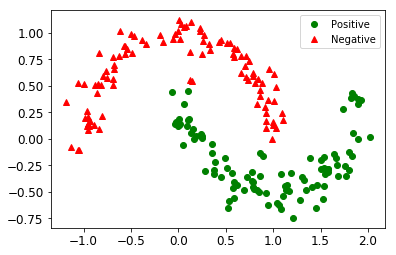

In [16]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [17]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tensorboard --logdir=tf_logs

In [18]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.1).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    reset_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20180731224548/
  batch size: 39
  learning_rate: 0.004430375245218265
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20180731224828/
  batch size: 55
  learning_rate: 0.0017826497151386947
  training: .....................
  precision: 0.9696969696969697
  recall: 0.9696969696969697
Iteration 2
  logdir: tf_logs/logreg-run-20180731225030/
  batch size: 78
  learning_rate: 0.00203228544324115
  training: .....................
  precision: 0.9696969696969697
  recall: 0.9696969696969697
Iteration 3
  logdir: tf_logs/logreg-run-20180731225153/
  batch size: 55
  learning_rate: 0.004491523825137997
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/logreg-run-20180731225354/
  batch size: 78
  learning_rate: 0.07963234721775589
  training: .....................
  precision: 0.980198019801

### Submit your notebook

Submit your solution in Blackboard
Make sure you rename your notebook to    
W7_UTORid.ipynb    
Example W7_adfasd01.ipynb
